# Mineração de dados para classificação de diabetes

A previsão que este trabalho se propõe a fazer é derivada de uma base de dados encontrada [neste](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf) link (CDC), cujos dados incluem informações de diversos pacientes, como o índice de massa corpórea e o número de filhos, e suas propensões em serem diabéticos, pré-diabético ou não.


### Ferramentas para uso e download

Algumas bibliotecas famosas são utilizadas para a análise de dados feitas no mundo todo, mas também para o [entendimento de negócio](#scrollTo=ZIe7TEiAA-4v) e [preparação dos dados](#scrollTo=Rg3v-19GrGeo).

Podem ser citadas as seguintes:

* **Principais em análise de dados**:
  * `Pandas` para ler, analisar, manipular e entender os dados, especialmente os estruturados.
  * `Seaborn` e `Pyplot` (`matplotlib`) para visualização de dados, fornecendo uma ampla variedade de tipos de gráficos e parâmetros personalizáveis. A primeira é uma biblioteca construída em cima do `matplotlib` e fornece padrões de visualização adicionais, bem como temas.
  * `numpy` é uma biblioteca para computação numérica, fornecendo funções — a exemplo da `unique` — para trabalhar com matrizes e *arrays*.
* **Algoritmos**: a classe `LogisticRegression` do `sklearn.linear_model` é usada para classificação, enquanto as classes `KMeans` e `Birch` do `sklearn.cluster` são usadas para clusterização. Veja a lista completa no código.
* **Métricas**: as funções `f1_score` e `accuracy` do `sklearn.metrics` são usadas para avaliar o desempenho da classificação, mas estão contidas em `classification_report`. A matriz de confusão também por importada para este ambiente. Todas estas foram utilizadas.
* **Melhorias na seleção**: já a classe `model_selection` permite fazer avaliações do modelo.

* **Ferramentas secundárias**:
  * A biblioteca `math` é usada no código para funções secundárias.
  * Finalmente, o módulo `gc` é usado para *garbage collection* (coleta de lixo, respectivo à memória).

In [ ]:
!pip install efficient-apriori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# para balanceamento da base
from imblearn.under_sampling import RandomUnderSampler

# para uso a partir da modelagem
from sklearn.linear_model import LogisticRegression # classificação
from sklearn.ensemble import RandomForestClassifier # classificação
from sklearn.tree import DecisionTreeClassifier # classificação
from sklearn.cluster import KMeans, Birch # clusterização
from sklearn.neighbors import KNeighborsClassifier # classificação

# associação
from efficient_apriori import apriori # for association analysis

# métricas e pós-modelagem
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# bibliotecas e métodos secundários
from math import sqrt
from numpy import unique, mean, std
import gc # gargabe collector

In [ ]:
# biblioteca para lidar com os avisos/alertas (warning)
import warnings

In [ ]:
# define o padrão de pseudo-aleatoriedade para o np.random
RAND_STATE = 2023
np.random.seed(2023)

In [ ]:
# define o número máximo de iterações para o LogisticRegression (aumentar pode incrementar as chances de convergência)
LR_MAX_ITER = 200

In [ ]:
# define hiperparâmetros para apriori
MIN_SUPPORT = 0.4
MIN_CONFIDENCE = 0.2

Primeiras entradas (importações e arquivo de dados)

Lê o arquivo como um DataFrame, carregando o arquivo '.csv'  baixado pelo link disponibilizado anteriormente.

O arquivo foi deixado na pasta a ser acessada, pelo seguinte comando (ele será trazido para este espaço):

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para acessar o arquivo, salve-o conforme a variável definida abaixo, ou altere-a

In [ ]:
# define o diretório (pasta) do arquivo, dentro do drive
DATASET_PATH = "Colab Notebooks/MID/diabetes_012_health_indicators_BRFSS2015.csv"



### Entendimento do negócio e dos dados

Variável utilizada (dataset): `dtset`.

#### Análise dos atributos e seus valores

Como previsto, o dataset possui 22 colunas e apresenta um número gigante de entradas (mais de 250 mil). Alguns atributos são:

* fumante
* ataque do coração
* infarte
* atividade física
* consumo de vegetais
* ingestão de bebida alcoólica
* realização de exames médicos
* qualidade de saúde, mental ou física
* dificuldade para caminhar
* sexo, idade, escolaridade e renda

A maioria tem valor significativo a ser explorado porque fica difícil estabelecer  vínculo fixo entre eles (ou alguns) e a classe: ter ou não diabetes ou pré-diabetes. O documento original descreve:

 1.   **Diabetes_012**
 1.   **HighBP**
    * *Ever Told Blood Pressure High*
 2.   **HighChol**
    * *High Cholesterol Calculated Variable*
 3.   **CholCheck** (*Cholesterol Checked Calculated Variable*)
    * *Blood cholesterol is a fatty substance found in the blood. Have you EVER had your blood cholesterol checked?*
 4.   **BMI**
    * *Computed body mass index*
 5.   **Smoker**, 0-1 (não-sim):
    * *Smoked at Least 100 Cigarettes*
 6.   **Stroke** (*Ever Diagnosed with a Stroke*), 0-1 (não-sim):
    * *(Ever told) you had a stroke*.
 7.   **HeartDiseaseorAttack**, 0-1 (não-sim):
    * *Ever Diagnosed with Heart Attack*
    * *(Ever told) you had a heart attack, also called a myocardial infarction?*
    * R: sim, não, não sabe/sem certeza ou recusou.
 8.   **PhysActivity**, 0-1 (não-sim):
    * *Exercise in Past 30 Days*
    * *During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?*
 9.   **Fruits**, 0-1 (não-sim para 1 ou mais vezes consumidas por mês)
    * *How many times did you eat fruit?*
    * Modificada para: "durante o último mês, ingeriu uma fruta ou mais por dia?"
 10.  **Veggies**: coluna removida por apresentar dados incertos (alterados em relação à base original).
 11.  **HvyAlcoholConsump** (cf. *Avg alcoholic drinks per day in past 30*)
    * *One drink is equivalent to a 12-ounce beer, a 5-ounce glass of wine, or  drink with one shot of liquor. During the past 30 days, on the days when you drank, about how many drinks did you drink on the average?*, 0-1 (não-sim, com relação ao consumo forte)
 12.  **AnyHealthcare**, 0-1 (não-sim)
    * Ter algum plano ou cobertura de saúde: *Do you have any kind of health care coverage, including health insurance, prepaid plans such as HMOs, or
government plans such as Medicare, or Indian Health Service?*

 13.  **NoDocbcCost** (*Could Not See Doctor Because of Cost*), 0-1 (não-sim)
   * Resposta binária para a indagação se "não pode ver um médico nos últimos 12 meses (1 ano) por conta de custos ou despesas".
   * A maioria dos respondentes apresentou "não" como resposta, ou seja, puderam ter o acompanhamento de um médico.

 14.  **GenHlth** (*general health*: grupo saúde geral, ou bem estar), 1-5
   * 1: "excelente", 2: "muito boa", 3: "boa", 4: "mediana", 5: "ruim"
 15.  **MentHlth** (saúde mental), 0-30
   * *Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many
days during the past 30 days was your mental health not good?* ("Por quantos dias, nos últimos 30 dias, sua saúde mental não foi aparentemente boa")
 16.  **PhysHlth** (grupo saúde física), 0-30

  * Por quantos dias durante os 30 últimos dias sua saúde fisica este ruim. Pergunta completa foi (em inglês): *\[n\]ow thinking about your physical health, which includes physical illness and injury, for how many days during the past
30 days was your physical health not good?*

 17.  **DiffWalk** (dificuldade de caminhar), 0-1
 18.  **Sex** (sexo), 0-1 (M, F)
 19.  **Age** (idade), 1-13 (18-80+). A descrição original é a seguinte ("age" é idade):
  * 1 Idade 18 a 24
  * 2 Idade 25 a 29
  * 3 Idade 30 a 34
  * 4 Idade 35 a 39
  * 5 Idade 40 a 44
  * 6 Idade 45 a 49
  * 7 Idade 50 a 54
  * 8 Idade 55 a 59
  * 9 Idade 60 a 64
  * 10 Idade 65 a 69
  * 11 Idade 70 a 74
  * 12 Idade 75 a 79
  * 13 Idade 80 ou mais velho
 20.  **Education** (escolaridade), 1-6

  * 1 Nunca frequentou escola ou apenas jardim de infância
* 2 Graus 1 a 8 (Fundamental)
* 3 séries 9 a 11 (algumas escolas de ensino médio)
* 4ª série 12 ou GED (pós-graduação do ensino médio)
* 5 Faculdade 1 ano a 3 anos (alguma faculdade ou escola técnica)
* 6 Faculdade 4 anos ou mais (graduação universitária)

 21.  **Income** (renda), 1-8

 Os casos omissos foram removidos, tais como quando o participante optou por responder ou não respondeu satisfatoriamente.

Note que os valores não foram preenchidos na integralidade porque à época o site não estava acessível.

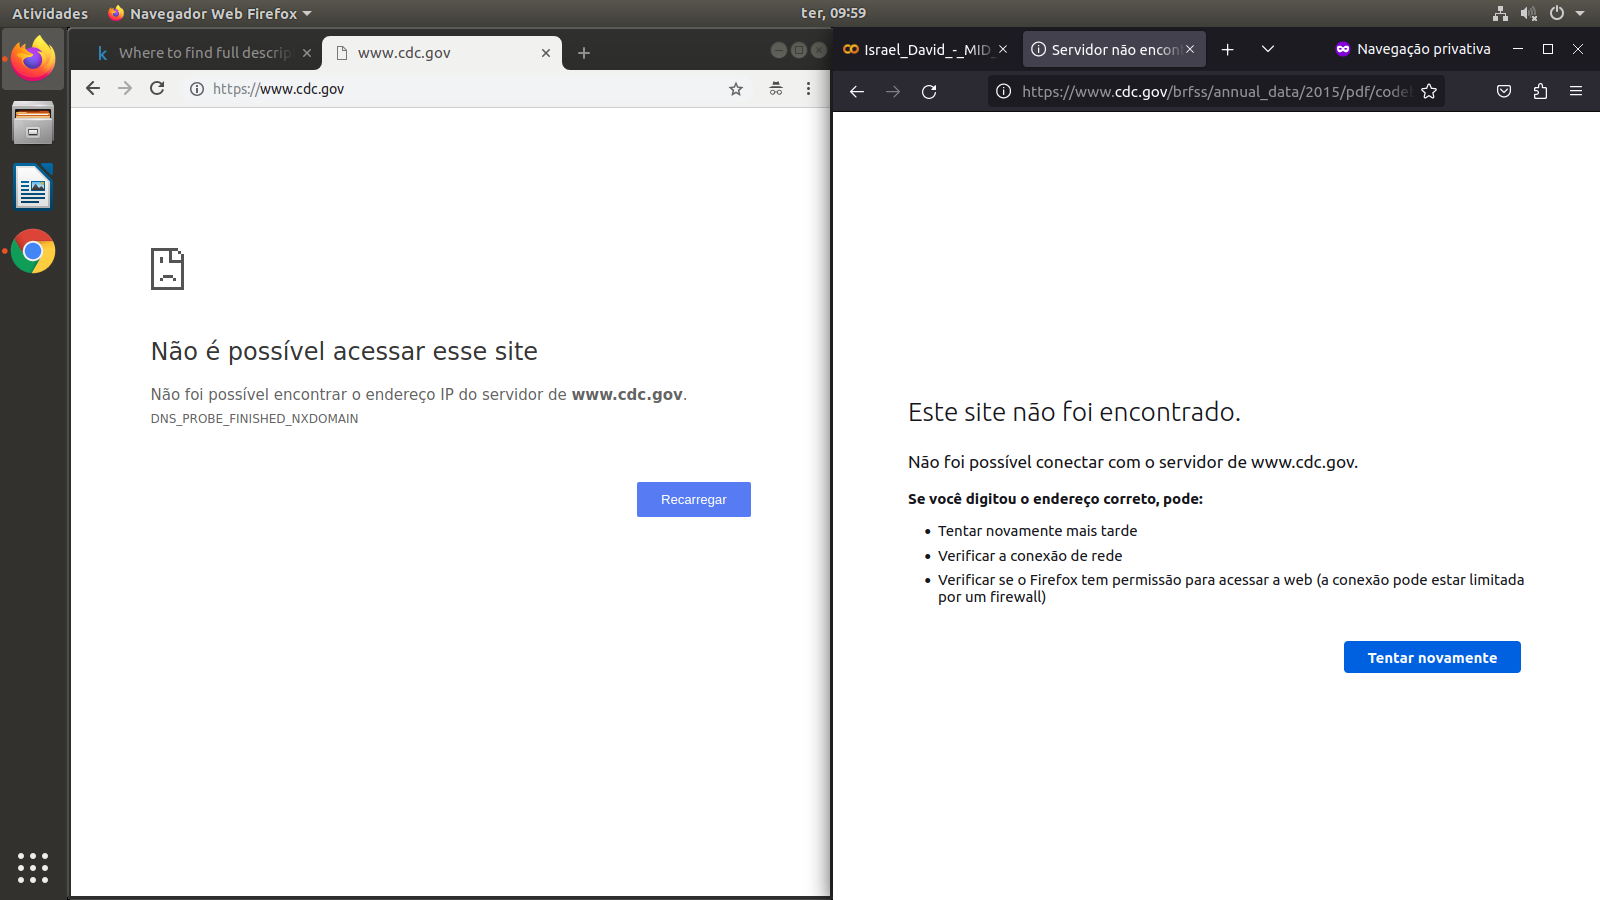

#### Base de dados: coleta e rotinas

In [ ]:
dtset = pd.read_csv("/content/drive/MyDrive/"+DATASET_PATH)

In [ ]:
# define método para contar linhas e colunas
def exibir_lins_cols(dataset):
    lin_num, col_num = dataset.shape
    print(str(lin_num).rjust(7), 'lins')
    print(str(col_num).rjust(7), 'cols')

#### Análise exploratória

In [ ]:
dtset.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


A seguir, são apresentadas informações gerais da base de dados, a incluir: número de linhas e colunas; informações de colunas, contagem de não nulos e tipos; e descrição estatística das colunas númericas.

Notar que há mais de 250 mil entradas (linhas), o que pode representar um entrave à execução dos algoritmos, particularmente por conta de limitações computacionais. Em razão disso, a etapa de preparação conta com a ***remoção aleatória*** de algumas colunas.

In [ ]:
# exibe tupla linha-coluna (formato 2D)
exibir_lins_cols(dtset)

 253680 lins
     22 cols


In [ ]:
dtset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
# Descrição resumida
dtset.describe(include='all')

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [ ]:
# Descrição de todas colunas
description = None
with pd.option_context('display.max_columns', 23):
    print(dtset.describe(include='all'))

        Diabetes_012         HighBP       HighChol      CholCheck  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.296921       0.429001       0.424121       0.962670   
std         0.698160       0.494934       0.494210       0.189571   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       1.000000       1.000000   
max         2.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000              0.000000  

Continua a descrição

In [ ]:
# Descreve a coluna BMI
dtset['BMI'].describe()

count    253680.000000
mean         28.382364
std           6.608694
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: BMI, dtype: float64

A contagem de dias com "saúde física" negativa é uma análise importante para entender o mapeamento entre os valores e o mapeamento feito para as regras de associação.

0.0     160052
30.0     19400
2.0      14764
1.0      11388
3.0       8495
5.0       7622
10.0      5595
15.0      4916
4.0       4542
7.0       4538
20.0      3273
14.0      2587
25.0      1336
6.0       1330
8.0        809
21.0       663
12.0       578
28.0       522
29.0       215
9.0        179
18.0       152
16.0       112
27.0        99
17.0        96
24.0        72
22.0        70
26.0        69
13.0        68
11.0        60
23.0        56
19.0        22
Name: PhysHlth, dtype: int64


<Axes: >

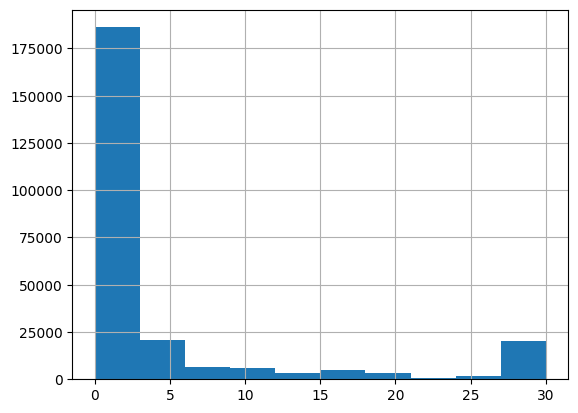

In [ ]:
print(dtset["PhysHlth"].value_counts())
dtset["PhysHlth"].hist()

De todos os tipos presentes, apenas dois estão  definidos: `float` e `int` (64). E nenhuma das entradas está nula, o que facilita o trabalho de quem faz a etapa de pré-processamento.

In [ ]:
dtset.dtypes.value_counts() #conta a quantidade de cada "d-tipo"

float64    22
dtype: int64

In [ ]:
dtset.isnull().sum() #soma a quantidade de nulos em cada linha

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

A maioria ampla da classe é considerada "não diabética". Note que a base de dados é desbalanceada por razões estatísticas — há um viés provável.

<Axes: xlabel='Diabetes_012', ylabel='count'>

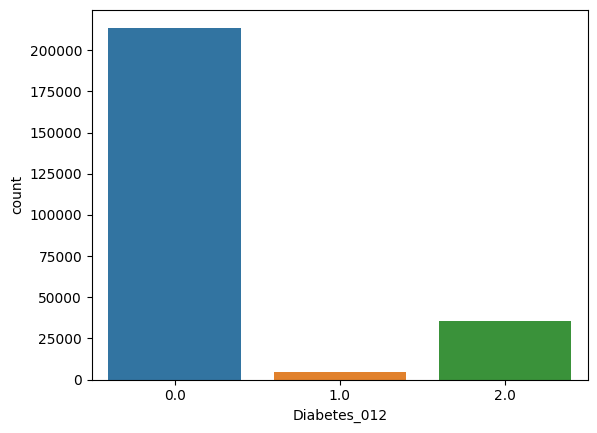

In [ ]:
sns.countplot(x=dtset["Diabetes_012"])

É feito também um comparativo entre a prevalência de diabetes e o índice de massa corpórea (BMI) e a existência de atividade física.

O gráfico a seguir não pode ser dado como conclusivo, mas demonstra uma possível análise de viés: poderia ser concluído que há uma maior prevalência de diabéticos (roxo) quando se realiza atividade física (eixo horizontal). Porém a maior proporção destes se deve ao fato de que a maioria das pessoas entrevistadas realiza atividade física.

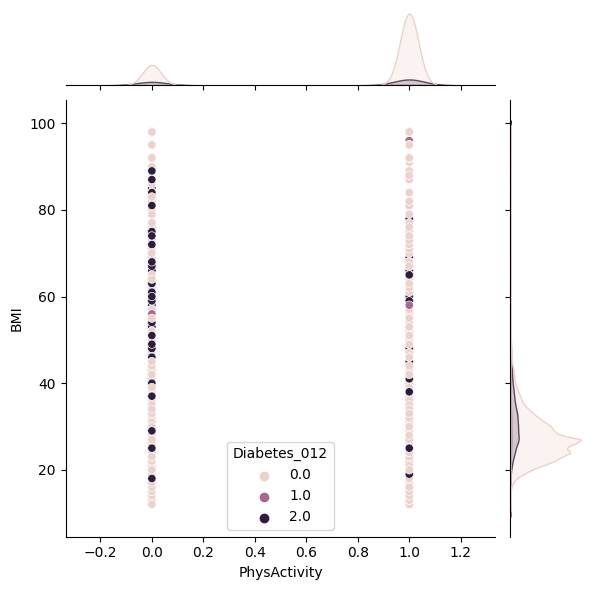

In [ ]:
sns.jointplot(data=dtset, x='PhysActivity', y='BMI', hue='Diabetes_012')

Veja a seguir o mapa de **fator de correlação**: entre a classe e os autenticação, a correlação não passa de 31%. E 7 dos 22 possuem corr > 10%.

<Axes: >

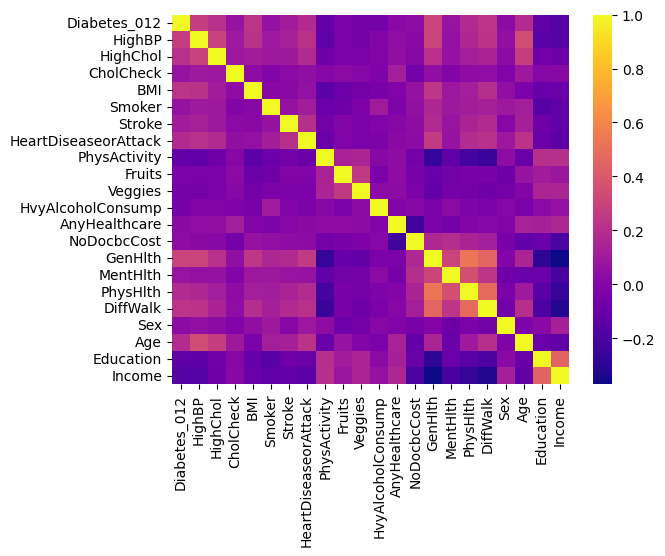

In [ ]:
sns.heatmap(dtset.corr(), cmap="plasma")

In [ ]:
dtset.corr()["Diabetes_012"].sort_values(ascending=False)

Diabetes_012            1.000000
GenHlth                 0.302587
HighBP                  0.271596
BMI                     0.224379
DiffWalk                0.224239
HighChol                0.209085
Age                     0.185026
HeartDiseaseorAttack    0.180272
PhysHlth                0.176287
Stroke                  0.107179
MentHlth                0.073507
CholCheck               0.067546
Smoker                  0.062914
NoDocbcCost             0.035436
Sex                     0.031040
AnyHealthcare           0.015410
Fruits                 -0.042192
HvyAlcoholConsump      -0.057882
Veggies                -0.058972
PhysActivity           -0.121947
Education              -0.130517
Income                 -0.171483
Name: Diabetes_012, dtype: float64

#### Seleção e Aplicação de Técnicas de Modelagem

A utilização de métodos de clustering, associação e classificação pode auxiliar na identificação de padrões e subpopulações de indivíduos com características semelhantes, bem como na previsão de condições clínicas, como diabetes ou pré-diabetes.


*   Um dos métodos que podem ser utilizados é o **clustering**, que busca agrupar indivíduos com base em suas características de saúde, identificando subpopulações com perfis semelhantes. Isso pode permitir uma análise mais detalhada de fatores de risco e grupos de indivíduos com maior probabilidade de desenvolver determinada condição clínica.

*   Outra técnica que pode ser útil é a **associação**, que busca identificar padrões de co-ocorrência entre características de saúde, identificando conjuntos de atributos que estejam fortemente associados com determinada condição. Esses conjuntos podem ser utilizados como características em algoritmos de classificação, por exemplo.

*   A **classificação**, por sua vez, permite a previsão de condições clínicas com base em características de saúde dos indivíduos. Algoritmos como as florestas aleatórias ou as redes neurais podem ser utilizados para essa finalidade, permitindo uma análise mais precisa e preditiva.

Por fim, é importante destacar que a combinação dessas técnicas pode ser uma abordagem ainda mais poderosa. Por exemplo, é possível utilizar o *clustering* para identificar subpopulações com características semelhantes e, em seguida, aplicar algoritmos de classificação dentro de cada subgrupo para prever condições clínicas. Além disso, os conjuntos de características identificados por meio da associação podem ser utilizados em algoritmos de classificação para aumentar a acurácia das previsões.

Em suma, o uso de técnicas de aprendizado de máquina pode ser uma ferramenta valiosa na análise de dados de saúde, permitindo uma melhor compreensão de fatores de risco e na previsão de condições clínicas.

A escolha das técnicas específicas não necessariamente representa essas possibilidades, mas é  feita com base nas características do conjunto de dados e nos objetivos da pesquisa.

## Preparação dos dados

*Esta etapa também pode ser guiada por algumas perguntas: “Como os valores nulos devem ser tratados? Os atributos estão nos formatos corretos? Será necessário fazer alguma fusão com outros dados? Quais variáveis serão utilizadas na modelagem?”* (Blog MBausPeslq)

* Variável utilizada para **clusterização**: `df_prep_clust`. Esta contém a "nova versão" de `dtset`, mas com tamanho reduzido.
* Variável para **classificação**: `df_prep_proposed_balan`. Segue o mesmo princípio, porém sem a redução de linhas.
* Variável-lista para **associação**: `list_assoc_X_df`.

Note que a convenção "*df*" ajuda a identificar que se trata de um *DataFrame* (Pandas).

In [ ]:
df_prep =  dtset

#### Remoção de coluna

Aqui será removida a coluna identificada por 'Veggies', conforme exposto na análise exploratória. `df_prep` ainda será utilizada por todas etapas à frente (a mudança se dá *inplace*, ou seja, com alteração do objeto original, `df_prep`).

In [ ]:
# remove a coluna e salva o dataset resultante
df_prep.drop(labels='Veggies', axis=1, inplace=True)

# mostra a diferença (a que foi removida)
set(dtset.columns)-set(df_prep.columns)

set()

In [ ]:
df_prep_proposed_balan = df_prep # guarda o mesmo conjunto, resguardando a quantidade original

#### Subconjunto para *clusterização*

Agora será retomada a base com uma redução prévia da base, de maneira randomizada. A resultante é a `df_prep_clust`.

In [ ]:
remove_n = int(0.7*dtset.shape[0]) # o número de linhas a remover, contadas do dataset original
drop_indices = np.random.choice(df_prep.index, remove_n, replace=False)
df_prep_clust = df_prep.drop(drop_indices)

In [ ]:
df_prep_clust

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253660,0.0,0.0,1.0,1.0,34.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,2.0,1.0,0.0,7.0,4.0,3.0
253661,0.0,1.0,0.0,1.0,33.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,3.0,0.0,2.0,1.0,0.0,6.0,6.0,6.0
253671,0.0,1.0,1.0,1.0,23.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,4.0,0.0,5.0,0.0,1.0,8.0,3.0,2.0
253673,0.0,1.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,14.0,4.0,0.0,1.0,3.0,6.0,8.0


#### Subconjunto para classificação (balanceado)

São utilizadas duas variáveis (`X` e `y`) para guardar as partes a serem balanceadas. As variáveis tem o final "to_be_balan" (*prestes a ser balanceada*). As principais **resultantes** são `X_clf` e `y_clf`.

In [ ]:
# antes de balancear
X_proposed_balan = df_prep_proposed_balan.drop("Diabetes_012", axis=1)
y_proposed_balan = df_prep_proposed_balan["Diabetes_012"]
y_proposed_balan.value_counts()

0.0    213703
2.0     35346
1.0      4631
Name: Diabetes_012, dtype: int64

In [ ]:
rnd_undersample = RandomUnderSampler(sampling_strategy='auto', 
                                         random_state=RAND_STATE)

# realiza a transformação duas vezes até o menor (4631 entradas)
X_clf, y_clf = rnd_undersample.fit_resample(X_proposed_balan, y_proposed_balan)
y_clf.value_counts()

0.0    4631
1.0    4631
2.0    4631
Name: Diabetes_012, dtype: int64

As contagens resultantes mostram as alterações realizadas. Então, para o primeiro `DataFrame`:

*   o número de **colunas** era `22`.
*   o número de **linhas** era `253.680`  (sugestões: redução de 70%, ou 177.576, a menos; ou de acordo com o *undersample*).

In [ ]:
# contagem final do subconjunto menor
exibir_lins_cols(df_prep_clust)

  76104 lins
     21 cols


In [ ]:
# contagem final do subconjunto maior
exibir_lins_cols(df_prep_proposed_balan)

 253680 lins
     21 cols


In [ ]:
# contagem do subconjunto para classificação (após sub-amostragem)
exibir_lins_cols(X_clf.join(y_clf))

  13893 lins
     21 cols


#### Para `apriori`: define lista categórica a partir de DataFrame

Note: RA é uma abreviação para "renda anual".

In [ ]:
df_map = {}
df_map['Diabetes_012'] = {
    0: "Sem diabetes",
    1: "Pré-diabetes",
    2: "Diabetes"}

df_map['HighBP'] = {
    0: "Sem pressão alta",
    1: "Teve pressão alta"
}

df_map['HighChol'] = {
    0: "Sem alto colesterol",
    1: "Teve alto colesterol"
}

df_map['CholCheck'] = {
    0: "Sem checagem de col.",
    1: "Verificação de col."
}

df_map['BMI'] = {
        (0.0, 18.5) :'Abaixo do peso',
        (18.5, 24.9) :'Peso adequado',
        (24.9, 29.9) :'Acima do peso',
        (29.9, 99.99) :'Obesidade'
}

df_map['Smoker'] = {
    0: "Não fumante",
    1: "Fumante"
}

df_map['Stroke'] = {
    0: "Sem infarto",
    1: "Com infarto"
}

df_map['HeartDiseaseorAttack'] = {
    0: "Sem doença ou ataque cardíaco",
    1: "Teve doença ou ataque cardíaco"
}

df_map['PhysActivity'] = {
    0: "Sem atividade física",
    1: "Teve atividade física"
}

df_map['Fruits'] = {
    0: "Consumo baixo de frutas (<1/mês)",
    1: "Consumiu frutas regularmente (>1/mês)"
}

df_map['HvyAlcoholConsump'] = {
    0: "Sem consumo forte de álcool",
    1: "Teve consumo forte de álcool"
}

df_map["AnyHealthcare"] = {
    0: "Sem plano de saúde",
    1: "Com plano de saúde"
}

df_map["NoDocbcCost"] = {
    0: "Visita a um médico apesar dos custos",
    1: "Sem visita a um médico devido aos cursos"
}

df_map["GenHlth"] = {
    1: "Saúde excelente",
    2: "Saúde muito boa",
    3: "Saúde boa",
    4: "Saúde mediana",
    5: "Saúde ruim"
}

df_map["MentHlth"] = {
    (0, 7): "Emocional: problemas durante 1 semana",
    (7, 14): "Emocional: problemas entre 7 e 14 dias",
    (14, 21): "Emocional: problemas entre 14 e 21 dias",
    (21, 31): "Emocional: problemas por entre 21 e 31 dias"
}

df_map["PhysHlth"] = {
    (0, 0): "Saúde física: boa nos últimos 30 dias", # 62%
    (1, 7): "Saúde física (1m): negativa 7 dias no máximo",
    (7, 14): "Saúde física (1m): negativa entre 7 e 14 dias no máximo",
    (14, 21): "Saúde física (1m): negativa entre 14 e 21 dias no máximo",
    (21, 30): "Saúde física: negativa por mais de 21 dias no mês",
}

df_map["DiffWalk"] = {
    0: "Caminhar: sem dificuldade",
    1: "Caminhar: com dificuldade"
}

df_map['Sex'] = {
    0: "M",
    1: "F"
}

df_map['Age'] = {
    1: "Idade: 18 a 24",
    2: "Idade: 25 a 29",
    3: "Idade: 30 a 34",
    4: "Idade: 35 a 39",
    5: "Idade: 40 a 44",
    6: "Idade: 45 a 49",
    7: "Idade: 50 a 54",
    8: "Idade: 55 a 59",
    9: "Idade: 60 a 64",
    10: "Idade: 65 a 69",
    11: "Idade: 70 a 74",
    12: "Idade: 75 a 79",
    13: "Idade: 80 ou maior",
}

df_map["Education"] = {
    1: "Nunca frequentou escola, ou apenas jardim de infância",
    2: "Ensino fundamental",
    3: "Séries 9 a 11 (algumas escolas de ensino médio)",
    4: "Série 12 ou GED (seguindo o ensino médio)",
    5: "Faculdade 1 ano a 3 anos (alguma faculdade ou escola técnica)",
    6: "Faculdade 4 anos ou mais (graduação universitária)"
}

df_map["Income"] = {
    1: "RA: menos de $10.000", #4%
    2: "RA: entre $10.000 e $15.000", #4,47%
    3: "RA: entre $15.000 e $20.000", #6,12%
    4: "RA: entre $20.000 e $25.000", #7,39%
    5: "RA: entre $25.000 e $35.000", #8,95%
    6: "RA: entre $35.000 e $50.000", #11,88%
    7: "RA: entre $50.000 e $75.000", #13,27%
    8: "RA: $75.000 ou mais" # 26,32%
}

print("São", len(df_map.keys()), "colunas")

São 21 colunas


In [ ]:
# define a chave de acordo com um intervalo de valores (float)
def categ_range(x, df_mapper):
  for key in df_mapper:
    if x >= key[0] and x <= key[1]:
      return df_mapper[key]

In [ ]:
df_prep_assoc_categ = pd.DataFrame()

# percorre as colunas
# identifica se a coluna está com mapeamento feito (correspondência do nome no dicionário)
# e preenche o Dataframe de categorias, segundo o mapeamento
for col in df_prep.columns:
    mapping_types_set = set()

    if col not in df_map.keys():
      # pula mapeamento de coluna não prevista
      continue
    else:
      mapping_types_set = set(type(k) for k in df_map[col].keys())
      if len(mapping_types_set) > 1:
          print(col, 'possui mais de um tipo:', mapping_types_set)
          continue

    if tuple in mapping_types_set:
      # existe uma tupla (intervalo) para mapear
      df_prep_assoc_categ[col] = X_clf.join(y_clf)[col].apply(categ_range, df_mapper=df_map[col])
    else:
      # o mapeamento pode ocorrer de forma direta (simples)
      df_prep_assoc_categ[col] = X_clf.join(y_clf)[col].map(df_map[col])

df_prep_assoc_categ

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,Sem diabetes,Teve pressão alta,Sem alto colesterol,Verificação de col.,Obesidade,Não fumante,Sem infarto,Sem doença ou ataque cardíaco,Teve atividade física,Consumiu frutas regularmente (>1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde ruim,Emocional: problemas por entre 21 e 31 dias,Saúde física: negativa por mais de 21 dias no mês,Caminhar: com dificuldade,F,Idade: 50 a 54,Faculdade 4 anos ou mais (graduação universitá...,RA: entre $10.000 e $15.000
1,Sem diabetes,Teve pressão alta,Sem alto colesterol,Verificação de col.,Acima do peso,Não fumante,Sem infarto,Sem doença ou ataque cardíaco,Teve atividade física,Consumiu frutas regularmente (>1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde boa,Emocional: problemas durante 1 semana,Saúde física (1m): negativa entre 7 e 14 dias ...,Caminhar: sem dificuldade,F,Idade: 50 a 54,Faculdade 1 ano a 3 anos (alguma faculdade ou ...,RA: $75.000 ou mais
2,Sem diabetes,Sem pressão alta,Teve alto colesterol,Verificação de col.,Acima do peso,Fumante,Sem infarto,Sem doença ou ataque cardíaco,Teve atividade física,Consumiu frutas regularmente (>1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde muito boa,Emocional: problemas durante 1 semana,Saúde física (1m): negativa 7 dias no máximo,Caminhar: sem dificuldade,M,Idade: 50 a 54,Série 12 ou GED (seguindo o ensino médio),RA: entre $25.000 e $35.000
3,Sem diabetes,Sem pressão alta,Sem alto colesterol,Verificação de col.,Obesidade,Não fumante,Sem infarto,Sem doença ou ataque cardíaco,Teve atividade física,Consumiu frutas regularmente (>1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde boa,Emocional: problemas durante 1 semana,Saúde física: boa nos últimos 30 dias,Caminhar: sem dificuldade,M,Idade: 50 a 54,Faculdade 4 anos ou mais (graduação universitá...,RA: entre $50.000 e $75.000
4,Sem diabetes,Teve pressão alta,Teve alto colesterol,Verificação de col.,Peso adequado,Não fumante,Sem infarto,Sem doença ou ataque cardíaco,Teve atividade física,Consumiu frutas regularmente (>1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde boa,Emocional: problemas durante 1 semana,Saúde física: boa nos últimos 30 dias,Caminhar: sem dificuldade,M,Idade: 55 a 59,Faculdade 1 ano a 3 anos (alguma faculdade ou ...,RA: $75.000 ou mais
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13888,Diabetes,Sem pressão alta,Teve alto colesterol,Verificação de col.,Obesidade,Não fumante,Sem infarto,Sem doença ou ataque cardíaco,Sem atividade física,Consumo baixo de frutas (<1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde mediana,Emocional: problemas entre 14 e 21 dias,Saúde física: negativa por mais de 21 dias no mês,Caminhar: com dificuldade,F,Idade: 55 a 59,Faculdade 1 ano a 3 anos (alguma faculdade ou ...,RA: entre $15.000 e $20.000
13889,Diabetes,Teve pressão alta,Sem alto colesterol,Verificação de col.,Obesidade,Não fumante,Sem infarto,Sem doença ou ataque cardíaco,Teve atividade física,Consumiu frutas regularmente (>1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde ruim,Emocional: problemas por entre 21 e 31 dias,Saúde física: negativa por mais de 21 dias no mês,Caminhar: com dificuldade,M,Idade: 40 a 44,Faculdade 1 ano a 3 anos (alguma faculdade ou ...,RA: entre $15.000 e $20.000
13890,Diabetes,Teve pressão alta,Teve alto colesterol,Verificação de col.,Obesidade,Fumante,Com infarto,Sem doença ou ataque cardíaco,Teve atividade física,Consumiu frutas regularmente (>1/mês),...,Com plano de saúde,Visita a um médico apesar dos custos,Saúde boa,Emocional: problemas durante 1 semana,Saúde física: boa nos últimos 30 dias,Caminhar: sem dificuldade,M,Idade: 65 a 69,Faculdade 1 ano a 3 anos (alguma 

In [ ]:
# define uma lista a partir do Dataframe de dados categóricos
# e exibe uma entrada aleatória (de acordo com o tamanho)
list_assoc_df = [tuple(lin) for lin in df_prep_assoc_categ.values.tolist()]
list_assoc_df[np.random.randint(len(df_prep_assoc_categ))]

('Sem diabetes',
 'Sem pressão alta',
 'Sem alto colesterol',
 'Verificação de col.',
 'Peso adequado',
 'Fumante',
 'Sem infarto',
 'Sem doença ou ataque cardíaco',
 'Teve atividade física',
 'Consumiu frutas regularmente (>1/mês)',
 'Sem consumo forte de álcool',
 'Com plano de saúde',
 'Visita a um médico apesar dos custos',
 'Saúde mediana',
 'Emocional: problemas durante 1 semana',
 'Saúde física: boa nos últimos 30 dias',
 'Caminhar: sem dificuldade',
 'M',
 'Idade: 55 a 59',
 'Faculdade 4 anos ou mais (graduação universitária)',
 'RA: entre $50.000 e $75.000')

## Modelagem

*O modelo começa a tomar forma e podemos ver os primeiros resultados [...]. Com a definição de qual modelo será utilizado, devem ser definidos quais atributos serão variáveis na construção deste modelo.* (Blog MBausPeslq)

In [ ]:
try:
  del dtset # remove dados anteriores
except:
  dtset = None
  del dtset

gc.collect()

0

Aqui a matriz `X_clust` (2D) é o mesmo conjunto de dados da etapa de prepação, `df_prep_clust`, mas sem a coluna-classe, a qual não tem utilidade para a clusterização.

`X_clf` (2D) tem propriedades similares, mas tem origem na variável com o balanceamento nas entradas (`X_clf`) -- é definida para a classificação a partir de `df_prep_proposed_balan`. `y_clf` (1D) é a coluna alvo.

In [ ]:
# define X_clust: o mesmo, mas sem a coluna-classe por conta do aprendizado sem supervisão
# não guarda a coluna-classe (1D)
X_clust = df_prep_clust.drop(['Diabetes_012'], axis=1)

In [ ]:
X_clust

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
8,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253660,0.0,1.0,1.0,34.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,2.0,1.0,0.0,7.0,4.0,3.0
253661,1.0,0.0,1.0,33.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,1.0,0.0,6.0,6.0,6.0
253671,1.0,1.0,1.0,23.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,5.0,0.0,1.0,8.0,3.0,2.0
253673,1.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,14.0,4.0,0.0,1.0,3.0,6.0,8.0


In [ ]:
# Opcional: redefinição: utilizar uma base desbalanceada
# X_clf = df_prep_proposed_balan.drop(['Diabetes_012'], axis=1)
# y_clf = df_prep_proposed_balan['Diabetes_012'].squeeze() # "converte" para o pandas.core.series.Series

In [ ]:
y_clf

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13888    2.0
13889    2.0
13890    2.0
13891    2.0
13892    2.0
Name: Diabetes_012, Length: 13893, dtype: float64

### Clusterização

#### Conceitos e fatos aplicados

Alguns dos algoritmos feitos para o _clustering_ (_clusterização_) são:

1. K-Means
1. Mini Batch K-Means
1. BDScan
1. Affinity Propagation
1. BIRCH
1. Agglomerative Clustering

O método KMeans concede um algoritmo em que há uma soma dos quadrados intra-clusters (*within-clusters sum-of-squares* -- wcss). Quando menor for esse valor, melhor. E o KMeans do `scikit-learn` dá-lhe o nome de **_inertia_**.

In [ ]:
# conjunto dos retornos da propriedade `inertia_`
wcss = []

#### KMeans aplicado

In [ ]:
def get_kmeans_labels(data, num_clusters):
    # Inicializa o KMeans com um número determinado de clusters
    kmeans = KMeans(n_clusters=num_clusters)

    # Ajusta o modelo
    kmeans.fit(data)

    # Retorna as especificações para cada entrada
    return kmeans.predict(data)

#### Birch aplicado

Aqui a função recebe não somente o número de *clusters*, mas também um limiar (*threshold*) de acordo com o qual o modelo será mais ou menos rigoroso.

In [ ]:
def get_birch_labels(data, n_clusters=3, threshold=1.5):
    # Define o modelo
    model = Birch(threshold=threshold, n_clusters=n_clusters)

    # Ajusta o modelo
    model.fit(data)

    # Determina um cluster para cada um
    return model.predict(data)

#### Obtendo as legendas (*labels*)

##### KMeans

A aplicação atual busca comparar as classes atuais (são 3) com uma clusterização e determinar a sua proximidade com os resultados.

Para isto, o **número de clusters** é determinado a 3 (ou 2, caso a classificação fosse binária).

In [ ]:
# Opção quando o número de clusters = 3
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cluster_labels = get_kmeans_labels(X_clust, num_clusters=3)

cluster_labels

array([1, 2, 2, ..., 2, 2, 2], dtype=int32)

In [ ]:
# Determina os diferentes valores possíveis para o retorno
unique(cluster_labels)

array([0, 1, 2], dtype=int32)

##### Birch

Obtém as definições com o algoritmo Birch, através da função já definida anteriormente.

In [ ]:
cluster_birch_labels = get_birch_labels(X_clust) # esta execução pode levar um maior tempo que o algoritmo anterior

In [ ]:
# retorna clusters únicos (opções)
unique(cluster_birch_labels)

array([0, 1, 2])

#### Organização em dataframe

In [ ]:
d = {"DiabetesLabels": df_prep_clust['Diabetes_012'],
     "KMeansLabels": cluster_labels,
     "BirchLabels": cluster_birch_labels} # variável temporária que guarda os tipos

df_clust = pd.DataFrame(data=d)
del d

df_clust

,DiabetesLabels,KMeansLabels,BirchLabels
2,0.0,1,0
3,0.0,2,1
4,0.0,2,1
5,0.0,2,1
8,2.0,1,0
...,...,...,...
253660,0.0,2,1
253661,0.0,2,1
253671,0.0,2,1
253673,0.0,2,2


### Classificação

A classificação possui alguns algoritmos interessantes que podem ser comparados aqui.

* **Logistic Regression** usa uma função logística posta predizer uma variável binária dependente, mas pode haver adaptações para suporte a múltiplas classes.
* **Decision Tree** (Árvore de Decisão) apresenta uma árvore com uma raiz a partir da qual fluem diversos fluxos de alternativas; é um algoritmo de aprendizado supervisionado usado também para classificação.  Para mais informações, acesse: https://www.ibm.com/topics/decision-trees.
* **Random Forest** usa árvores de decisão para chegar a previsões de dados, realizando um aprendizado conjunto (SAKAMOTO; FERNANDES, 2019).
* **KNN**, ou K-Nearest Neighbour, busca determinar `k` pontos e seus vizinhos, de modo a agrupar aqueles que são mais similares aos pontos "fixados"; neste caso, a similaridade pode ser medida pela distância euclidiana ou de minkowski. Para mais informações, acesse: https://www.hashtagtreinamentos.com/algoritmo-knn-ciencias-de-dados.

Observação: um dicionário neste notebook é utilizado, porém seu fim é simplesmente para resumo.

In [ ]:
clf_algorithms = ["RFC", "LR", "DTC", "KNN"]

In [ ]:
# Dicionário para coletar resultados
eval_clf = dict({"LR": {"acc": -1, "f1_score": -1, "report": "", "model": None}})
eval_clf.get("LR")

{'acc': -1, 'f1_score': -1, 'report': '', 'model': None}

In [ ]:
def clf_split():
    return train_test_split(X_clf, y_clf, test_size=0.2, random_state=RAND_STATE)

In [ ]:
# Bibliotecas utilizadas para divisão treino-teste
from sklearn.model_selection import train_test_split

Nota: este processo de divisão (split) tem previsão de ocorrência contínua, para evitar sobreposição de dados com variáveis de mesmo nome.

#### Regressão Logística

In [ ]:
(X_train, X_test, y_train, y_test) = clf_split()

A configuração da classe `LogisticRegression` para ser "multinomial" pode ser feita pelo parâmetro `multi_class`. Por conta disso, é preciso adequadar um `solver` a um que seja compatível com esta mudança, a saber: ‘newton-cg’, ‘sag’, ‘saga’ e ‘lbfgs'.

O *solver* do `LogisticRegression` (o parâmetro tem mesmo nome) escolhido foi `newton-cg` porque convergiu, diferentemente do que é padrão, do `sag` e do `saga`.

In [ ]:
lr = LogisticRegression(multi_class="multinomial", random_state = RAND_STATE, max_iter=LR_MAX_ITER, solver="newton-cg")
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200, multi_class='multinomial', random_state=2023,
                   solver='newton-cg')

In [ ]:
# treina o modelo com os dados de treino (adequa-o aos dados)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200, multi_class='multinomial', random_state=2023,
                   solver='newton-cg')

In [ ]:
# faz as previsões com o conjunto de teste
y_pred = lr.predict(X_test)

In [ ]:
# calcula a acurácia e f1-score do modelo
accuracy_lr = accuracy_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred=y_pred, average="micro")
clrep_lr = classification_report(y_test, y_pred)
cm_lr = confusion_matrix(y_test, y_pred)

# guarda as informações do modelo
eval_clf["LR"]["acc"] = accuracy_lr
eval_clf["LR"]["f1_score"] = f1_lr
eval_clf["LR"]["model"] = lr
eval_clf["LR"]["report"] = clrep_lr
eval_clf["LR"]["cm"] = cm_lr
eval_clf.keys()

del X_test, X_train, y_test, y_train

#### Floresta Aleatória

In [ ]:
# Repete a divisão
(X_train, X_test, y_train, y_test) = clf_split()

In [ ]:
# dada que o conjunto já foi dividido em treino e teste...
# cria um objeto de classificação Random Forest
# hiperparâmetros: número de estimadores e estado randomico
rfc = RandomForestClassifier(n_estimators=100, random_state=RAND_STATE)

In [ ]:
# ajuste: treina o modelo com os dados de treino
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=2023)

In [ ]:
# predição: faz as previsões com o conjunto de teste
y_pred = rfc.predict(X_test)

In [ ]:
# guarda métricas do modelo
accuracy_rfc = accuracy_score(y_test, y_pred)
f1_rfc = f1_score(y_test, y_pred=y_pred, average="micro")
clrep_rfc = classification_report(y_test, y_pred)
cm_rfc = confusion_matrix(y_test, y_pred)

# guarda as informações do modelo
eval_clf["RFC"] = dict()
eval_clf["RFC"]["acc"] = accuracy_rfc
eval_clf["RFC"]["f1_score"] = f1_rfc
eval_clf["RFC"]["model"] = rfc
eval_clf["RFC"]["report"] = clrep_rfc
eval_clf["RFC"]["cm"] = cm_rfc
eval_clf.keys()

del X_test, X_train, y_pred, y_test

#### Árvore de Decisão

O procedimento é extremamente parecido com o anterior. Sigla: dtc

In [ ]:
# Repete a divisão
(X_train, X_test, y_train, y_test) = clf_split()

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = dtc.predict(X_test)

In [ ]:
eval_clf["DTC"] = dict()
eval_clf["DTC"]["model"] = dtc
eval_clf["DTC"]["acc"] = accuracy_score(y_test, y_pred)
eval_clf["DTC"]["f1_score"] = f1_score(y_test, y_pred=y_pred, average="micro")
eval_clf["DTC"]["report"] = classification_report(y_test, y_pred)
eval_clf["DTC"]["cm"] = confusion_matrix(y_test, y_pred)

del X_train, X_test, y_train, y_test

#### KNN

As definições aqui são análogas às anteriores.

In [ ]:
# Repete a divisão
(X_train, X_test, y_train, y_test) = clf_split()

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
eval_clf["KNN"] = dict()
eval_clf["KNN"]["model"] = dtc
eval_clf["KNN"]["acc"] = accuracy_score(y_test, y_pred)
eval_clf["KNN"]["f1_score"] = f1_score(y_test, y_pred=y_pred, average="micro")
eval_clf["KNN"]["report"] = classification_report(y_test, y_pred)
eval_clf["KNN"]["cm"] = confusion_matrix(y_test, y_pred)

del X_train, X_test, y_train, y_test

### Associação

Como etapa secundária neste projeto, ficou estabelecido o algoritmo *apriori*.

In [ ]:
list_assoc_df[:1]

[('Sem diabetes',
  'Teve pressão alta',
  'Sem alto colesterol',
  'Verificação de col.',
  'Obesidade',
  'Não fumante',
  'Sem infarto',
  'Sem doença ou ataque cardíaco',
  'Teve atividade física',
  'Consumiu frutas regularmente (>1/mês)',
  'Sem consumo forte de álcool',
  'Com plano de saúde',
  'Visita a um médico apesar dos custos',
  'Saúde ruim',
  'Emocional: problemas por entre 21 e 31 dias',
  'Saúde física: negativa por mais de 21 dias no mês',
  'Caminhar: com dificuldade',
  'F',
  'Idade: 50 a 54',
  'Faculdade 4 anos ou mais (graduação universitária)',
  'RA: entre $10.000 e $15.000')]

In [ ]:
print("Suporte mínimo: ", MIN_SUPPORT)
print("Confiança mínima: ", MIN_CONFIDENCE)

Suporte mínimo:  0.4
Confiança mínima:  0.2


In [ ]:
itemsets, rules = apriori(list_assoc_df, min_support=MIN_SUPPORT, min_confidence=MIN_CONFIDENCE, verbosity=1)

Generating itemsets.
 Counting itemsets of length 1.
  Found 74 candidate itemsets of length 1.
  Found 20 large itemsets of length 1.
 Counting itemsets of length 2.
  Found 190 candidate itemsets of length 2.
  Found 104 large itemsets of length 2.
 Counting itemsets of length 3.
  Found 287 candidate itemsets of length 3.
  Found 261 large itemsets of length 3.
 Counting itemsets of length 4.
  Found 404 candidate itemsets of length 4.
  Found 368 large itemsets of length 4.
 Counting itemsets of length 5.
  Found 349 candidate itemsets of length 5.
  Found 310 large itemsets of length 5.
 Counting itemsets of length 6.
  Found 175 candidate itemsets of length 6.
  Found 157 large itemsets of length 6.
 Counting itemsets of length 7.
  Found 54 candidate itemsets of length 7.
  Found 46 large itemsets of length 7.
 Counting itemsets of length 8.
  Found 9 candidate itemsets of length 8.
  Found 6 large itemsets of length 8.
Itemset generation terminated.

Generating rules from items

In [ ]:
itemsets

{1: {('Teve pressão alta',): 8112,
  ('Sem alto colesterol',): 6101,
  ('Verificação de col.',): 13587,
  ('Obesidade',): 6542,
  ('Não fumante',): 7262,
  ('Sem infarto',): 13038,
  ('Sem doença ou ataque cardíaco',): 11905,
  ('Teve atividade física',): 9700,
  ('Consumiu frutas regularmente (>1/mês)',): 8545,
  ('Sem consumo forte de álcool',): 13302,
  ('Com plano de saúde',): 13208,
  ('Visita a um médico apesar dos custos',): 12399,
  ('F',): 6330,
  ('Emocional: problemas durante 1 semana',): 11662,
  ('Caminhar: sem dificuldade',): 10244,
  ('Sem pressão alta',): 5781,
  ('Teve alto colesterol',): 7792,
  ('Fumante',): 6631,
  ('M',): 7563,
  ('Saúde física: boa nos últimos 30 dias',): 7778},
 2: {('Caminhar: sem dificuldade', 'Com plano de saúde'): 9730,
  ('Caminhar: sem dificuldade', 'Consumiu frutas regularmente (>1/mês)'): 6452,
  ('Caminhar: sem dificuldade', 'Emocional: problemas durante 1 semana'): 9153,
  ('Caminhar: sem dificuldade', 'Não fumante'): 5736,
  ('Caminhar

In [ ]:
# exibe as regras por ordem (decrescente) de lift
for rule in sorted(rules, reverse=True, key=lambda rule: rule.lift):
  print(rule)  # documentação oficial: "prints the rule and its confidence, support, lift, ..."

A saída de streaming foi truncada nas últimas 5000 linhas.
{Caminhar: sem dificuldade, Sem consumo forte de álcool, Sem doença ou ataque cardíaco, Sem infarto, Teve atividade física, Verificação de col.} -> {Com plano de saúde} (conf: 0.957, supp: 0.442, lift: 1.007, conv: 1.149)
{Com plano de saúde} -> {Caminhar: sem dificuldade, Sem consumo forte de álcool, Sem doença ou ataque cardíaco, Sem infarto, Teve atividade física, Verificação de col.} (conf: 0.465, supp: 0.442, lift: 1.007, conv: 1.006)
{Sem infarto, Teve alto colesterol} -> {Com plano de saúde, Sem consumo forte de álcool} (conf: 0.917, supp: 0.473, lift: 1.007, conv: 1.074)
{Com plano de saúde, Sem consumo forte de álcool} -> {Sem infarto, Teve alto colesterol} (conf: 0.519, supp: 0.473, lift: 1.007, conv: 1.007)
{Verificação de col., Visita a um médico apesar dos custos} -> {Teve alto colesterol} (conf: 0.565, supp: 0.494, lift: 1.007, conv: 1.009)
{Teve alto colesterol} -> {Verificação de col., Visita a um médico apesar 

## Avaliação

*Etapa para avaliar se o resultado corresponde à expectativa do projeto.*

### Métricas

As métricas utilizadas neste projeto incluem a **acurácia** (*accuracy*), cujo valor pode ser igual ao da **pontuação f1** (f1-score). Essas e outras informações podem ser agregadas numa função só da mesma biblioteca.

A última é útil quando há mais de uma classe e que agrega falsos positivos, negativos e verdadeiros positivos e negativos em uma fórmula relativamente mais complexa.

Por fim, o relatório de classificação e a matriz de confusão são calculados utilizando as funções `classification_report()` e `confusion_matrix()`, respectivamente, para então serem imprimidos na tela.

### *Clustering*

In [ ]:
f1_kmeans = f1_score(y_true = df_clust['DiabetesLabels'], y_pred = df_clust['KMeansLabels'], average='micro')*100
f1_kmeans

16.644328813202986

In [ ]:
f1_birch = f1_score(y_true = df_clust['DiabetesLabels'], y_pred = pd.Series(cluster_birch_labels), average='micro')*100
f1_birch

11.980973404814463

### Classificação

Os resultados de cada algoritmo foram avaliados da seguinte forma:

* LR: levemente satisfatório
* RFC: razoavelmente satisfatório
* DTC: levemente não satisfatório
* KNN: o mesmo

dado um critério que não espere uma acurácia muito maior que 50%.

In [ ]:
# LR (LogisticRegression)
# percorre os dados armazenados
for alg in clf_algorithms:
    print(alg.center(30, "-"))
    try:
        alg_dict = eval_clf[alg].items()
        for (k,v) in alg_dict:
            print(str(k)+":", v, sep="\n", end="\n\n")
    except:
        print(alg, "is not created\n")

-------------RFC--------------
acc:
0.5044980208708169

f1_score:
0.5044980208708169

model:
RandomForestClassifier(random_state=2023)

report:
              precision    recall  f1-score   support

         0.0       0.58      0.61      0.59       923
         1.0       0.41      0.37      0.39       925
         2.0       0.51      0.54      0.52       931

    accuracy                           0.50      2779
   macro avg       0.50      0.50      0.50      2779
weighted avg       0.50      0.50      0.50      2779


cm:
[[560 210 153]
 [252 340 333]
 [150 279 502]]

--------------LR--------------
acc:
0.5322058294350486

f1_score:
0.5322058294350486

report:
              precision    recall  f1-score   support

         0.0       0.59      0.67      0.63       923
         1.0       0.46      0.33      0.39       925
         2.0       0.52      0.59      0.55       931

    accuracy                           0.53      2779
   macro avg       0.52      0.53      0.52      2779
wei

### Avaliação dos modelos

Procedimento para avaliação do modelo: com os métodos do `model_selection`.

Código de boa prática e seus comentarios são apresentado por *machine learning machinery*.

In [ ]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RAND_STATE)

In [ ]:
n_scores = dict()

# evaluate the model and collect the scores
for alg in clf_algorithms:
    model = eval_clf[alg]["model"]
    n_scores[alg] = cross_val_score(model, X_clf, y_clf, scoring='accuracy', cv=cv, n_jobs=-1) if (n_scores.get(alg, None) is None) else n_scores[alg]

In [ ]:
# Aponta a performance dos modelos
for alg in clf_algorithms:
    print(alg.ljust(5), "acurácia mediana: %.2f (%.2f)" % (mean(n_scores[alg]), std(n_scores[alg])))

RFC   acurácia mediana: 0.50 (0.01)
LR    acurácia mediana: 0.52 (0.01)
DTC   acurácia mediana: 0.42 (0.01)
KNN   acurácia mediana: 0.42 (0.01)


### Conclusões

Conclusões imediatas: não houve tempo hábil para execução de todos algoritmos previstos, haja vista as inúmeras possibilidades. Dessa forma, a associação aplicada ao conjunto deve ser melhor explorada em trabalhos futuros.

Desempenho:

* **Classificação**: a maioria das acurácias ficaram em torno de 50% nos algoritmos testados, o que está longe do ideal. Porém isso demonstra a natureza e complexidade do problema presente.
* **_Clustering_**: a pontuação dessa técnica foi bastante negativa, à medida que cerca de 20% é um valor bastante inferior. Isso demonstra as limitações do modelo, a dificuldade em separar bem os grupos (que sejam pré-diabeticos, diabéticos ou não) ou a ampla possibilidade de divisões possíveis.
* **Associação**: foi explorada de forma simples com um alguém, porém as regras de associação são melhores avaliadas um especialista no campo.

## Implementação (*deployment*)

O seguinte caso-exemplo tem o propósito apenas especulativo, porém serve para aplicar o modelo para entradas específicas.

Aqui, os atributos são preenchidos, e o modelo treinado é capaz de apresentar sua classificação esperada.

In [ ]:
#df_prep_clust[0:1].to_dict("list")

In [ ]:
d = {'HighBP': [0.0],
 'HighChol': [0.0],
 'CholCheck': [0.0],
 'BMI': [19.0],
 'Smoker': [0.0],
 'Stroke': [0.0],
 'HeartDiseaseorAttack': [0.0],
 'PhysActivity': [0.0],
 'Fruits': [1.0],
 'HvyAlcoholConsump': [0.0],
 'AnyHealthcare': [1.0],
 'NoDocbcCost': [0.0],
 'GenHlth': [5.0],
 'MentHlth': [30.0],
 'PhysHlth': [30.0],
 'DiffWalk': [1.0],
 'Sex': [0.0],
 'Age': [1.0], # 18 a 24 -> 1
 'Education': [6.0], # superior
 'Income': [2.0]} # renda: 8

df_x_deploy = pd.DataFrame(d)
df_x_deploy

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,30.0,30.0,1.0,0.0,1.0,6.0,2.0


In [ ]:
predictions = dict()

# Classifica este exemplo
for alg in clf_algorithms:
    try: predictions[alg] = eval_clf[alg]["model"].predict(df_x_deploy)
    except:
         predictions[alg] = None
         print(alg, "not saved")

predictions

{'RFC': array([0.]), 'LR': array([0.]), 'DTC': array([1.]), 'KNN': array([1.])}

In [ ]:
# Faz o mesmo com um algoritmo, porém com probabilidades
print("RFC:", eval_clf["RFC"]["model"].predict_proba(df_x_deploy)[0])
print("LR:", eval_clf["LR"]["model"].predict_proba(df_x_deploy)[0])

RFC: [0.54 0.32 0.14]
LR: [0.8342124  0.11358239 0.0522052 ]


## Opcional: aglutinação KMeans com otimização do número de clusters

Para obter um possível melhor número de clusters (experimental), é possível guardar os valores de _wcss_ (inertia) e buscar matematicamente o melhor ponto na "curva de cotovelo" (ela é exibida a seguir). Este passo é um demonstrativo daquilo que o algoritmo extraiu da base.

No entanto, para separar o conjunto em subconjuntos agrupados por `k` valores de classes requer um conhecimento de domínio maior, o que não cabe a este trabalho.

In [ ]:
# define o método para encontrar um bom número para k com o método do joelho
def optimize_kmeans(data, k_max=30):
    wcss = []
    nums = []

    for n in range(1, k_max):
         kmeans = KMeans(n_clusters=n)
         kmeans.fit(data)

         nums.append(n)
         wcss.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10,5))
    plt.plot(nums, wcss)
    plt.xlabel("Número de clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    return wcss

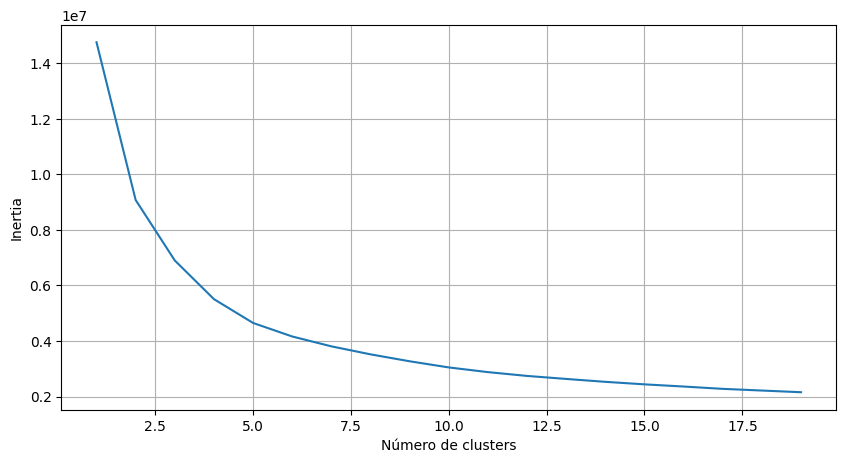

In [ ]:
# Determina os valores da soma dos quadrados intra-clusters, wcss
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    wcss = optimize_kmeans(df_prep_clust, 20)

In [ ]:
# Define a o modelo ("fórmula") de distância entre ponto e reta
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [ ]:
# Exibe o número de clusters calculado
op_clusters_n = 0
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    op_clusters_n = optimal_number_of_clusters(wcss)

In [ ]:
print(op_clusters_n)

6


In [ ]:
# Kmeans: opção quando o número de clusters = 6
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    #cluster_labels = get_kmeans_labels(X_clust, 6)

cluster_labels

array([1, 2, 2, ..., 2, 2, 2], dtype=int32)

In [ ]:
# Determina os diferentes valores possíveis para o retorno
unique(cluster_labels)

array([0, 1, 2], dtype=int32)

Como o valor encontrado antes foi 6 para o "número ótimo de clusters", este poderia ser usado na chamada da função KMeans. Seria, então, uma das melhores formas de agrupar as linhas dos dados.

## Referências Bibliográficas

BROWNLEE, Jason. **Clustering Algorithms with Python**. Disponível em: https://machinelearningmastery.com/clustering-algorithms-with-python/. Acesso em: 8 abr. 2023.

MATSUMOTO, F; FERNANDES, G. **Modelos de Predição: Random Forest**. Medium. \[S.l.\], 2019. Disponível em: https://medium.com/turing-talks/turing-talks-18-modelos-de-predi%C3%A7%C3%A3o-random-forest-cfc91cd8e524.


---

**Referências possíveis:**


BALAKRISHNAN, M. et al. Machine learning techniques for diagnosis of diabetes: A review. Journal of Medical Systems, v. 43, n. 5, p. 105, 2019.

CHAWLA, N. V. et al. Data mining for imbalanced datasets: An overview. In Data mining and knowledge discovery handbook, p. 853-867, Springer, 2010.

GARG, A.; SWAMINATHAN, A. An Overview of Data Mining Techniques. International Journal of Computer Applications, v. 117, n. 7, p. 1-6, 2015.

LIU, L. et al. A novel cluster-based method for diabetes classification. Computers in Biology and Medicine, v. 118, p. 103673, 2020.

MIRALLES, F. et al. Diabetes prediction using data mining: Model tuning and comparison. Informatics in Medicine Unlocked, v. 16, p. 100295, 2019.

RAI, P. et al. Feature selection using genetic algorithm and classification of diabetes dataset. In 2015 IEEE International Conference on Computational Intelligence and Computing Research (ICCIC), IEEE, p. 1-4, 2015.

SANTOS, C. A.; SILVA, A. L.; ARAÚJO, M. P. Previsão de mortalidade neonatal através de redes neurais artificiais: um estudo no Hospital Geral Clériston Andrade, Bahia. Revista Brasileira de Computação Aplicada, v. 13, n. 2, p. 9-22, 2021.